In [1]:
import os

# check if in kaggle 
if 'KAGGLE_CONTAINER_NAME' in os.environ:
    kaggle = True
    os.system('git clone https://github.com/lorenzo-saccaro/NNDL-recoloring-GAN')
    os.chdir('/kaggle/working/NNDL-recoloring-GAN')
    print(os.getcwd())
    # pull repo to update .py files
    os.system('git pull')
    # install needed packages
    os.system('pip install torchview')
    os.system('pip install torchinfo')
    os.system('pip install scikit-image')
    os.system('pip install scipy torchmetrics torch-fidelity lpips')
    
else:
    kaggle = False
    

In [2]:
from dataset import CocoDataset
from train import Trainer
from models import Generator, Discriminator
from losses import GeneratorCriterion, DiscriminatorCriterion
from torchvision.transforms import Compose, Resize
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
from torchinfo import summary
from torchview import draw_graph
from torchmetrics.image import UniversalImageQualityIndex, PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, FrechetInceptionDistance, LearnedPerceptualImagePatchSimilarity
import matplotlib.pyplot as plt


In [3]:
## RUN PARAMETERS ##

if kaggle:
    DATASET_ROOT = '/kaggle/input/coco-2017-dataset/coco2017'
else:
    DATASET_ROOT = 'C:\\Users\\loren\\Datasets\\coco2017'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metrics = [FrechetInceptionDistance(normalize=True, compute_on_cpu=True).to(device), # inputs in [0, 1] range
           StructuralSimilarityIndexMeasure(data_range=1.0, compute_on_cpu=True).to(device),
           PeakSignalNoiseRatio(data_range=1.0, compute_on_cpu=True).to(device),
           LearnedPerceptualImagePatchSimilarity(net_type='vgg', normalize=True, compute_on_cpu=True).to(device), # inputs in [0, 1] range
           UniversalImageQualityIndex(data_range=1.0, compute_on_cpu=True).to(device)]

BATCH_SIZE = 16
NUM_WORKERS = 2 if kaggle else 4

IMG_SIZE = 256
REMOVE_GRAY = True if kaggle else False # in kaggle needs to be done every time, in local only once
USE_LAB_COLORSPACE = True # whether to use LAB color space
USE_L1_LOSS = True # generator L1 loss
L1_LAMBDA = 100 # li loss coefficient
WGAN = False # whether to use Wasserstein loss
WGAN_GP = False # whether to use Wasserstein loss with gradient penalty
N_CRITIC = 1 if (not WGAN or WGAN_GP) else 5 # number of iteration of critic training
CLIP_WEIGHTS = WGAN and not WGAN_GP # whether to clip critic weights when using Wasserstein loss
CLIP_VALUE = 0.01 # max abs value for critic weights

DISCRIMINATOR_TYPE = 'patch_gan' # either DCGAN or patch_gan
PIXEL_CNN = False # use pixel CNN for decoder in generator or standard U-net Architecture
USE_INSTANCE_NORM = True if BATCH_SIZE==1 else False # norm layer type in models
GEN_IN_CHANNEL = 1 # always 1 channel for grayscale imgs
GEN_OUT_CHANNEL = 2 if USE_LAB_COLORSPACE else 3 # reconstruct only ab channels for Lab images,
DISC_IN_CHANNEL = GEN_IN_CHANNEL + GEN_OUT_CHANNEL # discriminator take both input and output images

# options for Trainer object
options = {
    'checkpoint_path': './gan.tar', # checkpoint file
    'use_lab_colorspace' : USE_LAB_COLORSPACE,
    'reset_training': False, # whether to reset or resuming training
    'num_epochs': 100,
    'clip_weights': CLIP_WEIGHTS,
    'clip_value': CLIP_VALUE,
    'n_critic': N_CRITIC,
    'output_path': './gan_imgs', # where to store generated images
    'plot_every_nstep': 10_000//BATCH_SIZE
}

os.system('mkdir {}'.format(options['output_path']))

C:\Users\loren\anaconda3\envs\NNDL-torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\loren\anaconda3\envs\NNDL-torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\loren\anaconda3\envs\NNDL-torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `UniversalImageQualityIndex` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


1

In [4]:
## SET SEEDS ##

SEED = 123456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ':4096:8'


# Dataset creation

## Define transformations to apply to each dataset input and output

In [5]:

# No need to include ToTensor, already applied in dataset
transforms_train = Compose([Resize((IMG_SIZE, IMG_SIZE))])
transforms_val = Compose([Resize((IMG_SIZE, IMG_SIZE))])
transforms_test = Compose([Resize((IMG_SIZE, IMG_SIZE))])

## Get dataset objects from helper function

In [6]:
train_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='train', transforms=transforms_train,
                            frac=0.2, use_lab_colorspace=USE_LAB_COLORSPACE, remove_gray=REMOVE_GRAY)

val_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='val', transforms=transforms_val,
                          frac=1, use_lab_colorspace=USE_LAB_COLORSPACE)

test_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='test', transforms=transforms_test,
                           frac=1, use_lab_colorspace=USE_LAB_COLORSPACE)


## Define corresponding dataloaders

In [7]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                              pin_memory=True, persistent_workers=True, drop_last=(1 <= len(train_dataset)%BATCH_SIZE <= 8))

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                            pin_memory=True, persistent_workers=True, drop_last=(1 <= len(val_dataset)%BATCH_SIZE <= 8))

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                             pin_memory=True, persistent_workers=True)


# Models Definition

### Generator

In [8]:
generator = Generator(use_instance_norm=USE_INSTANCE_NORM, in_channels=GEN_IN_CHANNEL, out_channels=GEN_OUT_CHANNEL, use_pixelTCL=PIXEL_CNN)
generator.to(device)
print(summary(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=45))


Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [16, 2, 256, 256]         --
├─ModuleList: 1-1                             --                        --
│    └─EncoderBlock: 2-1                      [16, 64, 128, 128]        --
│    │    └─Sequential: 3-1                   [16, 64, 128, 128]        --
│    │    │    └─Conv2d: 4-1                  [16, 64, 128, 128]        1,024
│    │    │    └─LeakyReLU: 4-2               [16, 64, 128, 128]        --
│    └─EncoderBlock: 2-2                      [16, 128, 64, 64]         --
│    │    └─Sequential: 3-2                   [16, 128, 64, 64]         --
│    │    │    └─Conv2d: 4-3                  [16, 128, 64, 64]         131,072
│    │    │    └─BatchNorm2d: 4-4             [16, 128, 64, 64]         256
│    │    │    └─LeakyReLU: 4-5               [16, 128, 64, 64]         --
│    └─EncoderBlock: 2-3                      [16, 256, 32, 32]         --
│    │    └

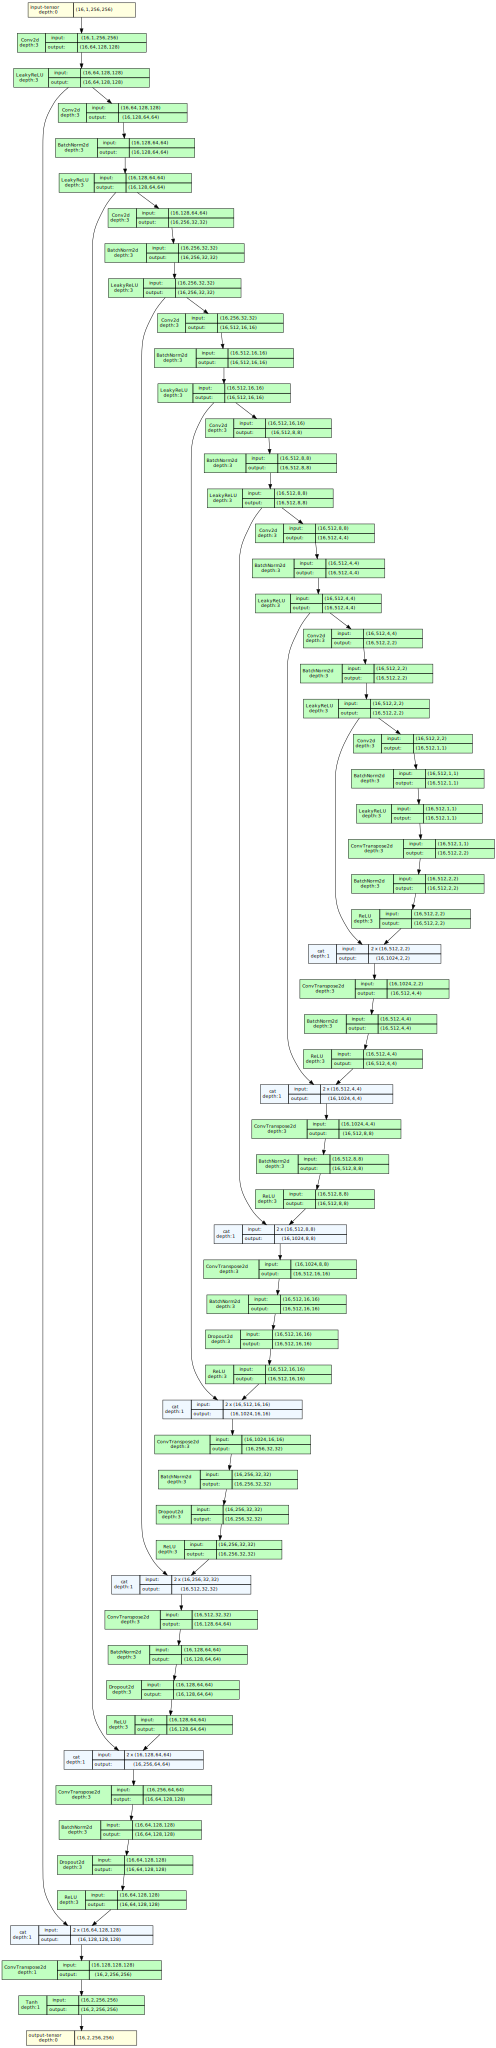

In [9]:
generator_graph = draw_graph(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
generator_graph.visual_graph

## Discriminator

In [10]:
discriminator = Discriminator(use_instance_norm=USE_INSTANCE_NORM, in_channels=DISC_IN_CHANNEL, disable_norm=WGAN_GP, network_type=DISCRIMINATOR_TYPE)
discriminator.to(device)
print(summary(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=4))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1, 30, 30]           --
├─ModuleList: 1-1                        --                        --
│    └─EncoderBlock: 2-1                 [16, 64, 128, 128]        --
│    │    └─Sequential: 3-1              [16, 64, 128, 128]        --
│    │    │    └─Conv2d: 4-1             [16, 64, 128, 128]        3,072
│    │    │    └─LeakyReLU: 4-2          [16, 64, 128, 128]        --
│    └─EncoderBlock: 2-2                 [16, 128, 64, 64]         --
│    │    └─Sequential: 3-2              [16, 128, 64, 64]         --
│    │    │    └─Conv2d: 4-3             [16, 128, 64, 64]         131,072
│    │    │    └─BatchNorm2d: 4-4        [16, 128, 64, 64]         256
│    │    │    └─LeakyReLU: 4-5          [16, 128, 64, 64]         --
│    └─EncoderBlock: 2-3                 [16, 256, 32, 32]         --
│    │    └─Sequential: 3-3              [16, 256, 32, 32]         --
│    │

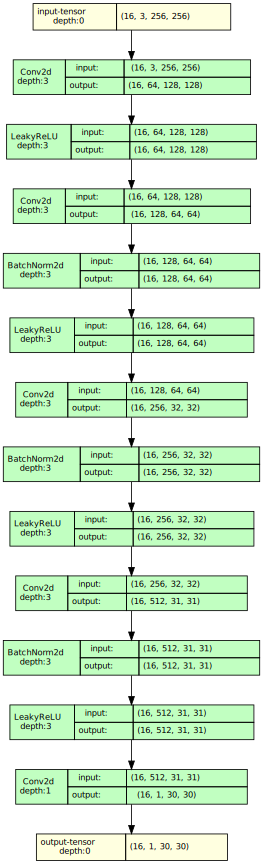

In [11]:
discriminator_graph = draw_graph(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
discriminator_graph.visual_graph

## Define Losses

In [12]:
disc_criterion = DiscriminatorCriterion(device=device, wgan=WGAN, wgan_gp=WGAN_GP)

In [13]:
gen_criterion = GeneratorCriterion(device=device, use_l1_loss=USE_L1_LOSS, l1_lambda=L1_LAMBDA, wgan=WGAN)

## Define Optimizers

In [14]:
if WGAN and not WGAN_GP: # wgan with clipping
    gen_opt = torch.optim.RMSprop(generator.parameters(), lr=5e-5)
    disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
else: # gan or wgan gp
    gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

## Lr Scheduler

In [15]:
gen_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(gen_opt, T_max=options['num_epochs'], eta_min=2e-5)
disc_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(disc_opt, T_max=options['num_epochs'], eta_min=2e-5)

# Training

In [16]:
trainer = Trainer(generator=generator, discriminator=discriminator,
                  gen_optimizer=gen_opt, disc_optimizer=disc_opt,
                  gen_scheduler=gen_lr_scheduler, disc_scheduler=disc_lr_scheduler,
                  gen_criterion=gen_criterion, disc_criterion=disc_criterion,
                  train_loader=train_dataloader, val_loader=val_dataloader,
                  device=device, metrics=metrics, options=options)


Loading checkpoint from ./gan.tar
Generator loaded
Discriminator loaded
Generator optimizer loaded
Discriminator optimizer loaded
Generator scheduler loaded
Discriminator scheduler loaded


In [ ]:
trainer.train()

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss_gan'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_gen_loss_gan'])
plt.legend(['train', 'val'])

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss_recon'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_gen_loss_recon'])
plt.legend(['train', 'val'])

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_disc_loss'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['val_disc_loss'])

In [ ]:
for metric in metrics:
    name = metric._get_name().lower()
    data = trainer.history['train_'+name]
    data_val = trainer.history['val_'+name]
    plt.plot(range(1, 1+trainer.history['elapsed_epochs']), data)
    plt.plot(range(1, 1+trainer.history['elapsed_epochs']), data_val)
    plt.legend(['train', 'val'])
    plt.title(name)
    plt.show()